# Segundo Trabajo Práctico: Machine Learning para Macroeconomía 2025-01
- Docente: Josué Cox (a20062953@pucp.edu.pe) 

- Fecha de Entrega: Hasta el miércoles 5 de febrero del 2025 a las 11:59 p.m. 

- Integrantes: Franco Vela, Paul Flores, Jhoany Rodríguez

## Ejercicio 3: Estimando un modelo de nivel local
Estime un modelo de nivel local para la inflación peruana para el 
periodo enero 2000 a diciembre 2019 (ver los datos en Inflacion_Peru.csv): 
1. Estime el modelo usando métodos frecuentistas (maximización de la 
verosimilitud) o bayesianos (simulación de la posterior mediante Gibbs 
sampling), escoja solo un método 
2. Muestre los gráficos de los estados estimados y las estimaciones de las 
varianzas.

C:\Users\Franc\AppData\Local\Temp\ipykernel_13724\3060857426.py:136: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Fecha'] = pd.to_datetime(df.iloc[:, 0])


Iteración 500 completada
Iteración 1000 completada
Iteración 1500 completada
Iteración 2000 completada
Iteración 2500 completada
Iteración 3000 completada
Iteración 3500 completada
Iteración 4000 completada
Iteración 4500 completada


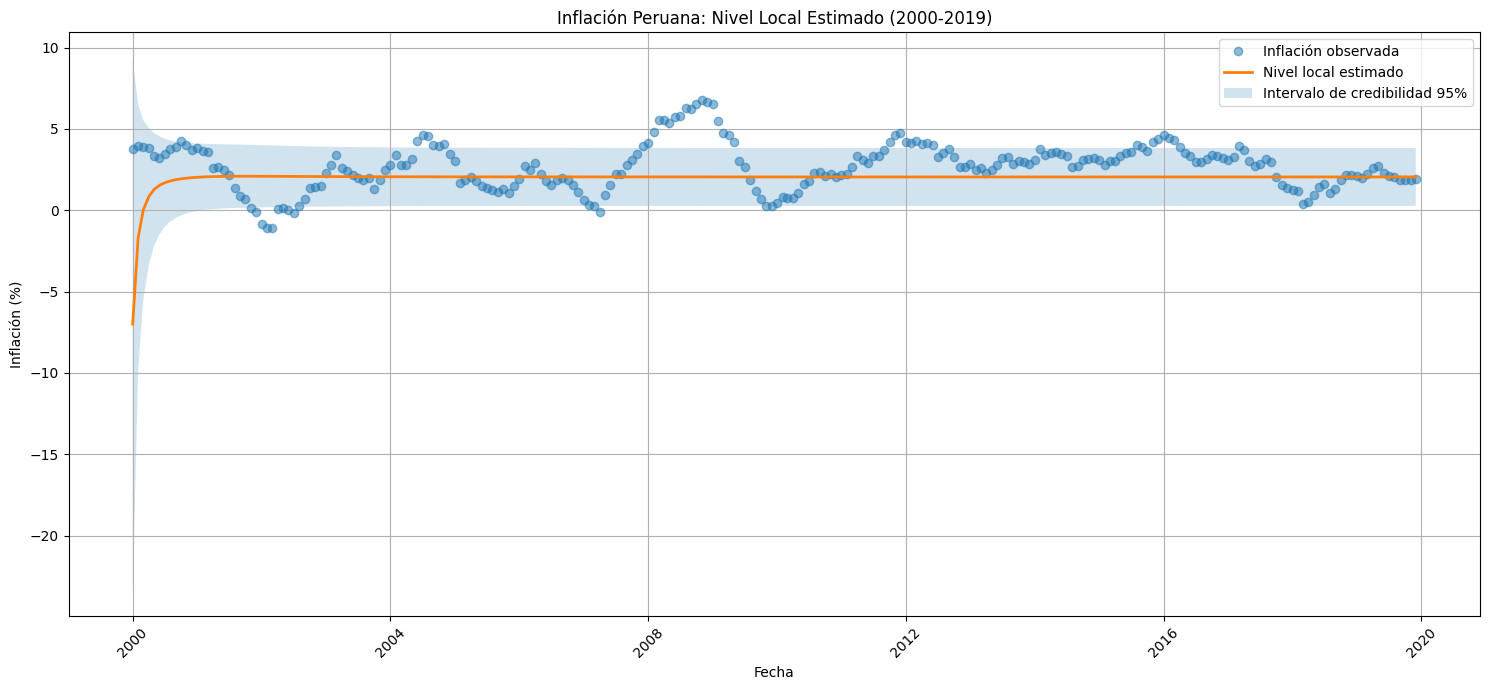

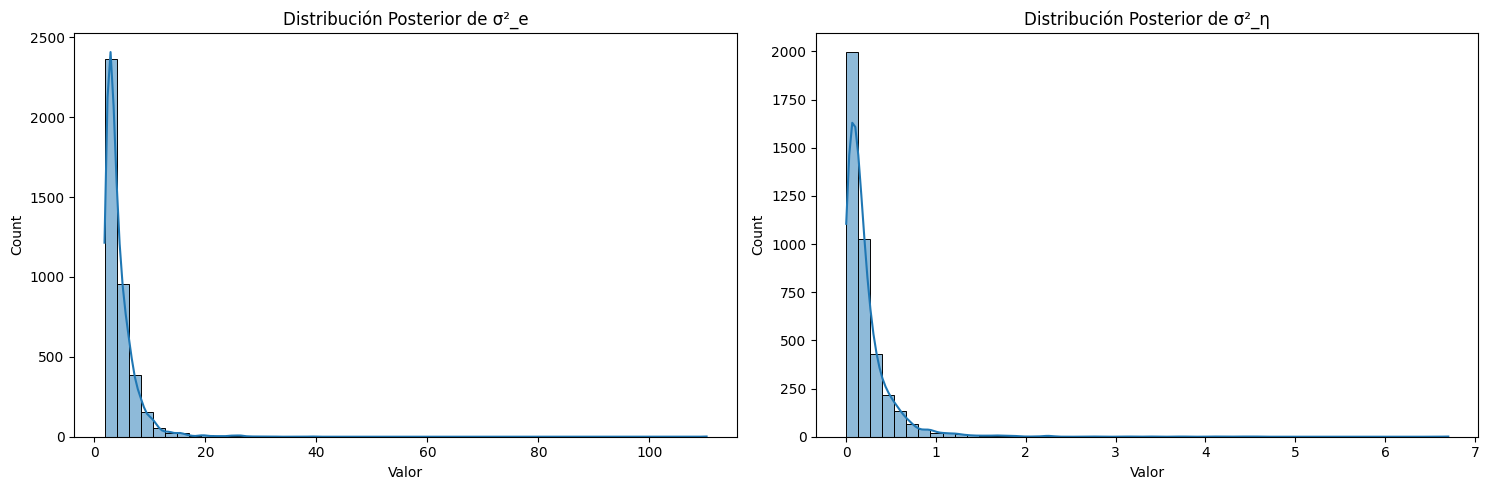


Estadísticas de las varianzas estimadas:
σ²_e (Varianza del Error de Observación):
  Media = 4.4898
  Desviación estándar = 3.3604

σ²_η (Varianza del Error de Estado):
  Media = 0.2149
  Desviación estándar = 0.3065


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import invgamma
import seaborn as sns

class LocalLevelModel:
    def __init__(self, y, dates, n_iterations=5000, burnin=1000):
        """
        Inicializa el modelo de nivel local usando muestreo de Gibbs
        y: datos observados (inflación)
        dates: fechas correspondientes a las observaciones
        n_iterations: número de iteraciones para Gibbs sampling
        burnin: número de iteraciones iniciales a descartar
        """
        self.y = y
        self.dates = dates
        self.n = len(y)
        self.n_iterations = n_iterations
        self.burnin = burnin
        
        # Almacenamiento para los estados y parámetros
        self.alpha = np.zeros((n_iterations, self.n))  # Estados
        self.sigma_e = np.zeros(n_iterations)  # Varianza del error de observación
        self.sigma_n = np.zeros(n_iterations)  # Varianza del error de estado
        
    def gibbs_sampling(self):
        """
        Implementa el algoritmo de Gibbs sampling con mejora en la eficiencia
        """
        # Valores iniciales
        self.sigma_e[0] = max(np.var(self.y) * 0.1, 1e-6)
        self.sigma_n[0] = max(np.var(self.y) * 0.1, 1e-6)
        self.alpha[0] = np.zeros(self.n)
        
        # Iteraciones de Gibbs sampling
        for t in range(1, self.n_iterations):
            self.alpha[t] = self.sample_states(self.sigma_e[t-1], self.sigma_n[t-1])
            self.sigma_e[t] = self.sample_sigma_e(self.alpha[t])
            self.sigma_n[t] = self.sample_sigma_n(self.alpha[t])
            
            if t % 500 == 0:
                print(f"Iteración {t} completada")
    
    def sample_states(self, sigma_e, sigma_n):
        """
        Muestrea los estados usando Forward Filtering Backward Sampling (FFBS)
        """
        states = np.zeros(self.n)
        mean = np.zeros(self.n)
        variance = np.zeros(self.n)
        
        # Forward Filtering
        mean[0] = self.y[0]
        variance[0] = sigma_e
        for t in range(1, self.n):
            pred_mean = mean[t-1]
            pred_var = variance[t-1] + sigma_n
            K = pred_var / (pred_var + sigma_e)
            mean[t] = pred_mean + K * (self.y[t] - pred_mean)
            variance[t] = pred_var * (1 - K)
            # Backward Sampling
        states[-1] = np.random.normal(mean[-1], np.sqrt(variance[-1]))
        for t in range(self.n - 2, -1, -1):
            mean_t = mean[t] + variance[t] / variance[t+1] * (states[t+1] - mean[t])
            var_t = max(variance[t] * (1 - variance[t] / variance[t+1]), 1e-6)
            states[t] = np.random.normal(mean_t, np.sqrt(var_t))
        
        return states
    
    def sample_sigma_e(self, alpha):
        """
        Muestrea la varianza del error de observación
        """
        e = self.y - alpha
        shape = (self.n - 1) / 2
        scale = max(np.sum(e**2) / 2, 1e-6)
        return invgamma.rvs(shape, scale=scale)
    
    def sample_sigma_n(self, alpha):
        """
        Muestrea la varianza del error de estado
        """
        n = np.diff(alpha)
        shape = (self.n - 1) / 2
        scale = max(np.sum(n**2) / 2, 1e-6)
        return invgamma.rvs(shape, scale=scale)
    
    def plot_results(self):
        """
        Genera gráficos de los resultados
        """
        post_burnin = slice(self.burnin, None)
        alpha_mean = self.alpha[post_burnin].mean(axis=0)
        alpha_std = self.alpha[post_burnin].std(axis=0)
        
        plt.figure(figsize=(15, 7))
        plt.plot(self.dates, self.y, 'o', label='Inflación observada', alpha=0.5)
        plt.plot(self.dates, alpha_mean, label='Nivel local estimado', linewidth=2)
        plt.fill_between(self.dates, 
                         alpha_mean - 2*alpha_std, 
                         alpha_mean + 2*alpha_std, 
                         alpha=0.2, label='Intervalo de credibilidad 95%')
        plt.title('Inflación Peruana: Nivel Local Estimado (2000-2019)')
        plt.xlabel('Fecha')
        plt.ylabel('Inflación (%)')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Gráficos de distribuciones de varianzas
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        sns.histplot(self.sigma_e[post_burnin], bins=50, kde=True, ax=axes[0])
        axes[0].set_title("Distribución Posterior de σ²_e")
        axes[0].set_xlabel("Valor")
        sns.histplot(self.sigma_n[post_burnin], bins=50, kde=True, ax=axes[1])
        axes[1].set_title("Distribución Posterior de σ²_η")
        axes[1].set_xlabel("Valor")
        
        plt.tight_layout()
        plt.show()
        
        # Imprimir estadísticas resumidas
        print("\nEstadísticas de las varianzas estimadas:")
        print(f"σ²_e (Varianza del Error de Observación):")
        print(f"  Media = {self.sigma_e[post_burnin].mean():.4f}")
        print(f"  Desviación estándar = {self.sigma_e[post_burnin].std():.4f}")
        print(f"\nσ²_η (Varianza del Error de Estado):")
        print(f"  Media = {self.sigma_n[post_burnin].mean():.4f}")
        print(f"  Desviación estándar = {self.sigma_n[post_burnin].std():.4f}")

# Cargar datos
df = pd.read_csv('Inflacion_Peru.csv')
df['Fecha'] = pd.to_datetime(df.iloc[:, 0])
inflacion = df['PN01273PM'].values 
fechas = df['Fecha']

mask = (fechas >= '2000-01-01') & (fechas <= '2019-12-31')
inflacion = inflacion[mask]
fechas = fechas[mask]

modelo = LocalLevelModel(inflacion, fechas, n_iterations=5000, burnin=1000)
modelo.gibbs_sampling()
modelo.plot_results()

## Ejercicio 4: Replicando resultado de Stock and Watson (2021)
Usaremos los datos de desempleo, inflación y la tasa de 
interés para la economía norteamericana para el periodo 1960:Q1 – 2000:Q4. 

1. Estima el modelo VAR con 4 rezagos 
2. Utilice restricciones cero de corto plazo recursivas (Choleski) asumiendo 
que la inflación y el desempleo reaccionan con rezagos a la política 
monetaria. En particular asumimos que
$$
\begin{bmatrix} 
\pi_t \\ u_t \\ r_t 
\end{bmatrix} 
= \sum_{p=1}^{4} \phi_p x_{t-p} + 
\begin{bmatrix} 
b_{11} & 0 & 0 \\ 
b_{21} & b_{22} & 0 \\ 
b_{31} & b_{32} & b_{33} 
\end{bmatrix} 
\begin{bmatrix} 
\epsilon_t^1 \\ \epsilon_t^2 \\ \epsilon_t^{MonPol} 
\end{bmatrix}
$$

Donde 𝜋 es la tasa de inflación, 𝑢 es la tasa de desempleo y 𝑟 es la tasa 
de política monetaria. Produzca las funciones de impulso respuesta (FIR) 
para el shock de política monetaria sobre las tres variables endógenas. 
Muestre las FIR con los intervalos de confianza al 95% 

3. Produzca gráficos mostrando la descomposición del error de predicción para cada variable endógena 
4. Produzca gráficos mostrando la descomposición histórica para cada 
variable endógena

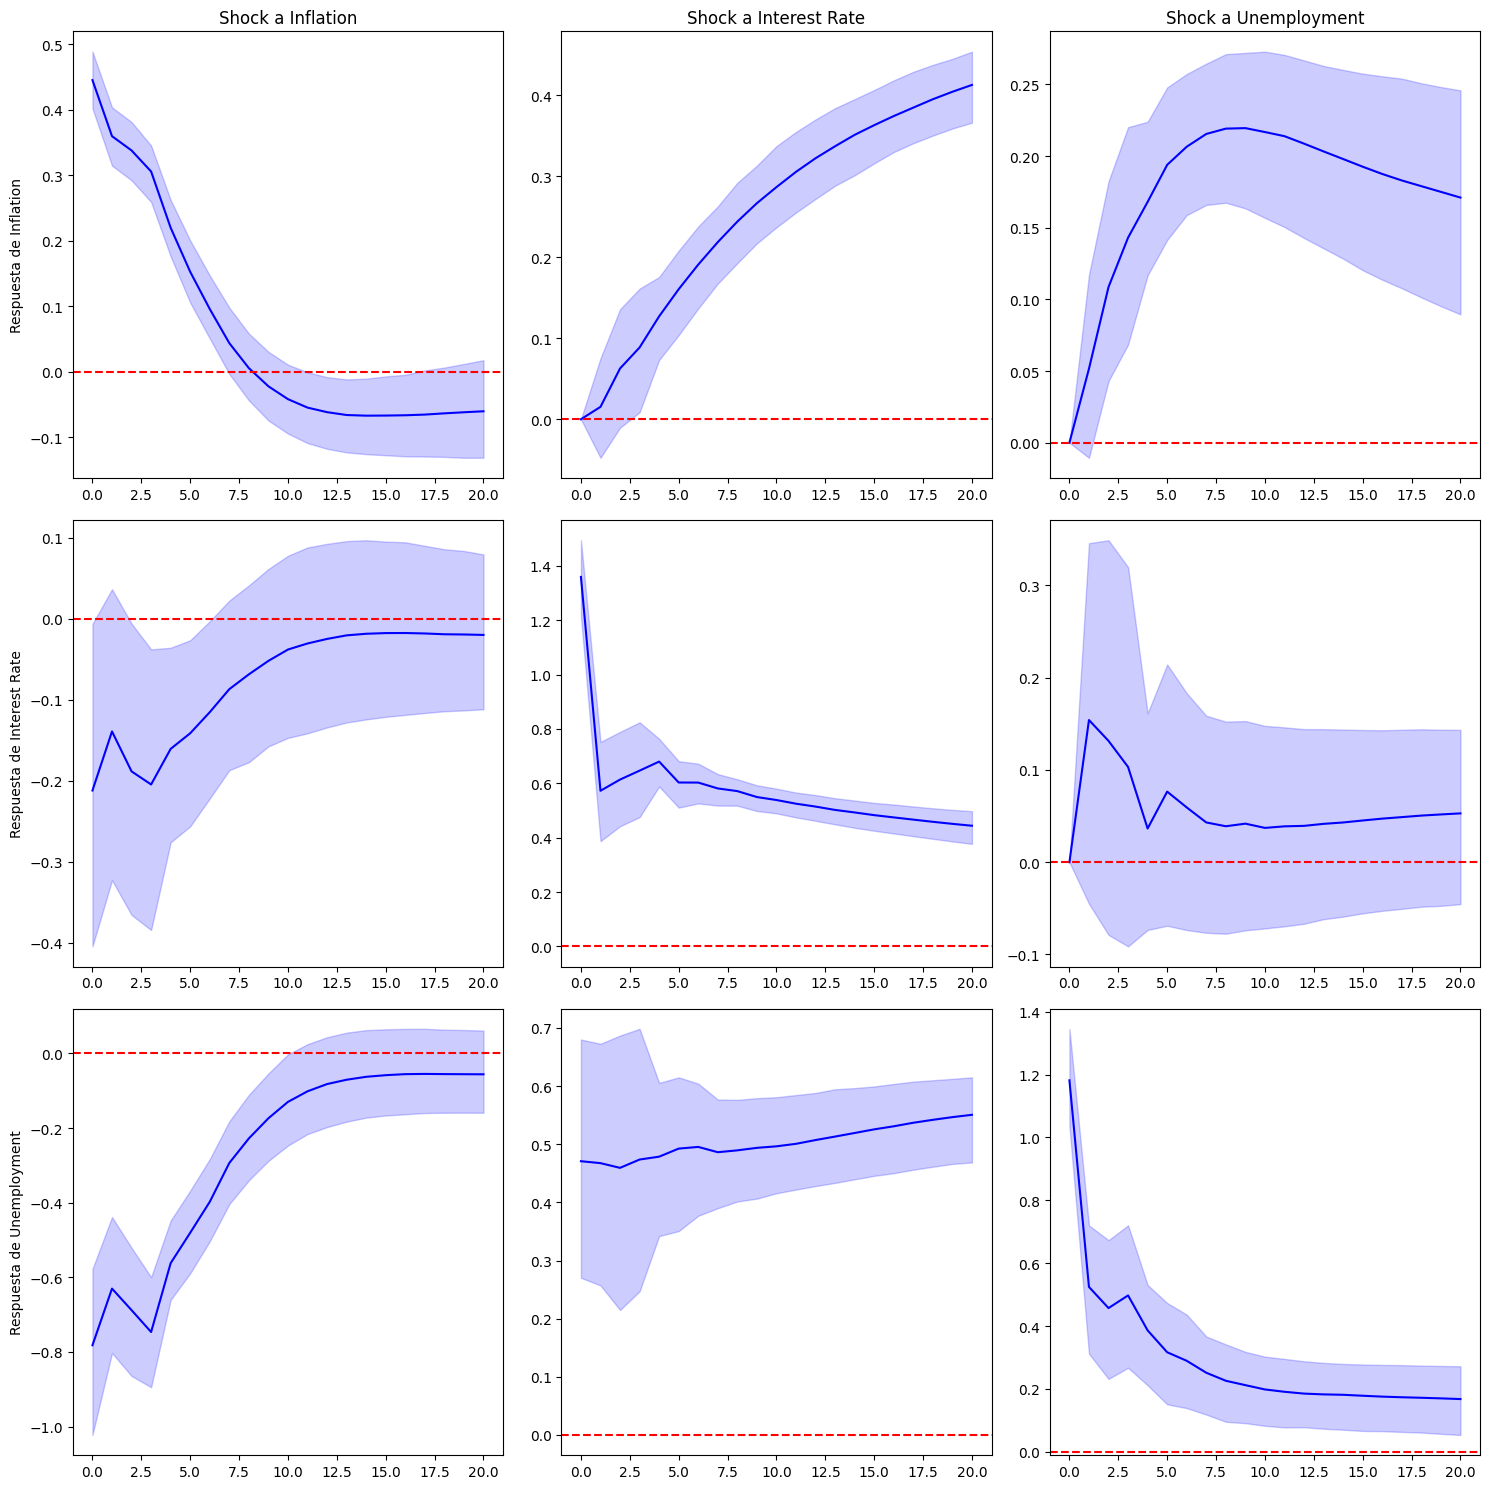

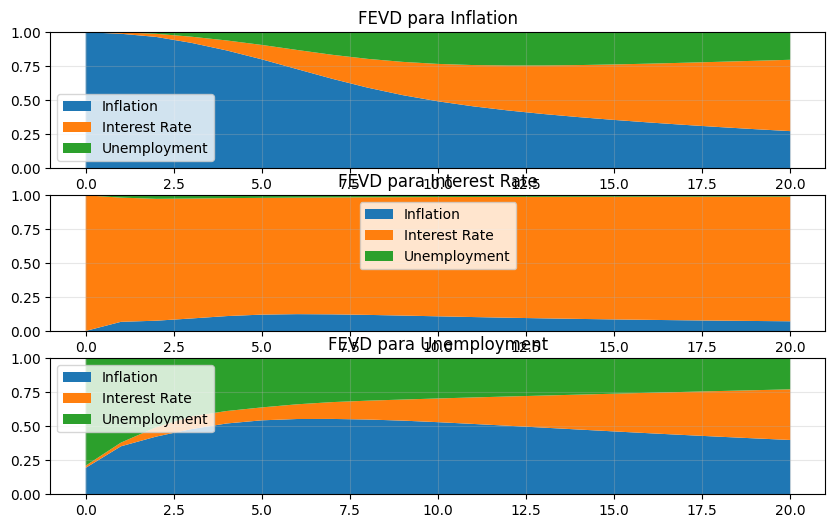

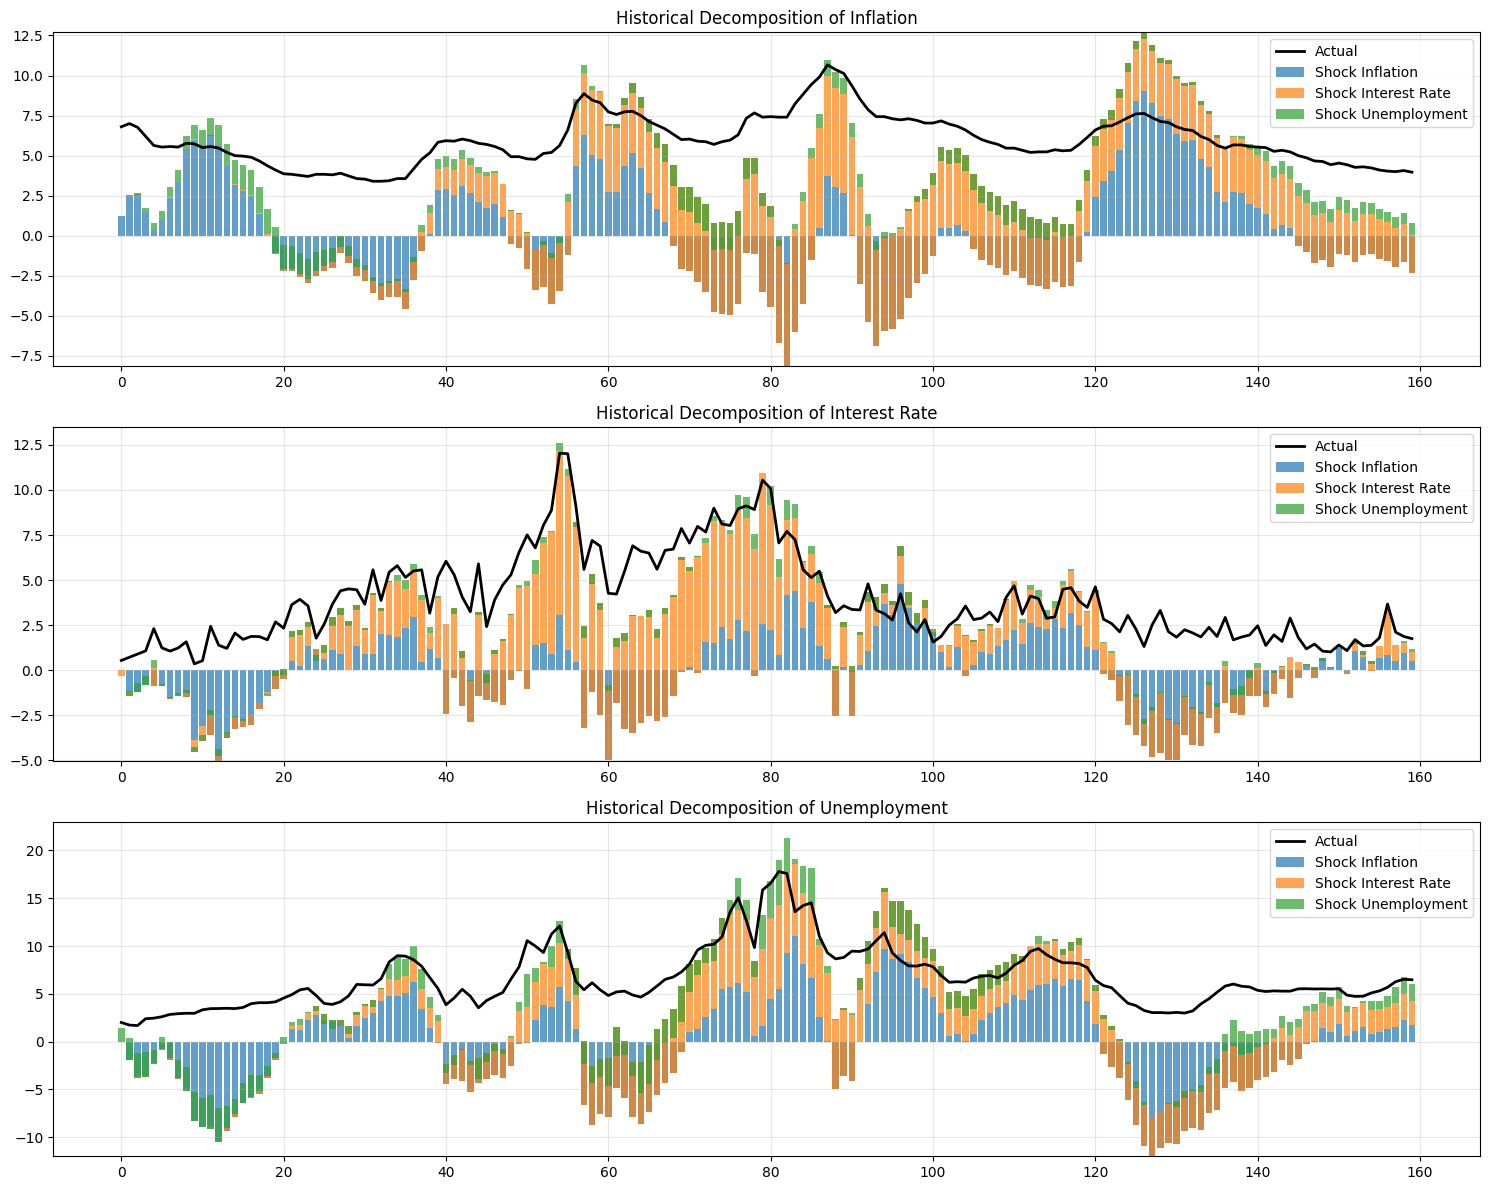

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modelo VAR
class VAR_Model:
    def __init__(self, data: np.ndarray, p: int):
        self.data = data
        self.T, self.n = data.shape
        self.p = p
        self.beta = None
        self.residuals = None
        self.sigma_u = None
        self.companion_matrix = None

    def create_lags(self):
        Z = self.data
        T, n = Z.shape
        p = self.p
        Y = Z[p:, :]
        X = np.zeros((T-p, n*p))

        for i in range(p):
            X[:, i*n:(i+1)*n] = Z[p-i-1:T-i-1, :]

        return Y, X

    def estimate_var(self):
        Y, X = self.create_lags()
        self.beta = np.linalg.inv(X.T @ X) @ X.T @ Y
        self.residuals = Y - X @ self.beta
        self.sigma_u = (self.residuals.T @ self.residuals) / (len(Y) - X.shape[1])

    def companion_form(self):
        n, p = self.n, self.p
        comp = np.zeros((n*p, n*p))

        for i in range(p):
            comp[0:n, i*n:(i+1)*n] = self.beta[i*n:(i+1)*n, :].T

        for i in range(1, p):
            comp[i*n:(i+1)*n, (i-1)*n:i*n] = np.eye(n)

        self.companion_matrix = comp

    def identification_choleski(self):
        return np.linalg.cholesky(self.sigma_u)

    def compute_irf(self, horizon):
        B = self.identification_choleski()
        irf = np.zeros((horizon+1, self.n, self.n))

        J = np.zeros((self.n, self.n * self.p))
        J[:, :self.n] = np.eye(self.n)

        F = self.companion_matrix
        irf[0] = B

        for h in range(1, horizon+1):
            irf[h] = J @ np.linalg.matrix_power(F, h) @ J.T @ B

        return irf

    def bootstrap_irf(self, horizon, N=1000, conf_level=0.95):
        irf_boot = np.zeros((N, horizon+1, self.n, self.n))

        Y_orig, X_orig = self.create_lags()
        beta_orig = self.beta.copy()
        data_orig = self.data.copy()
        residuals_orig = self.residuals.copy()

        for i in range(N):
            idx = np.random.randint(len(residuals_orig), size=len(residuals_orig))
            resid_boot = residuals_orig[idx]

            Y_boot = X_orig @ beta_orig + resid_boot
            data_boot = np.zeros_like(data_orig)
            data_boot[:self.p] = data_orig[:self.p]
            data_boot[self.p:] = Y_boot

            self.data = data_boot
            self.estimate_var()
            self.companion_form()

            B_boot = self.identification_choleski()
            irf_boot[i] = self.compute_irf(horizon)

        self.data = data_orig
        self.estimate_var()
        self.companion_form()

        alpha = (1 - conf_level) / 2
        lower = np.percentile(irf_boot, alpha*100, axis=0)
        upper = np.percentile(irf_boot, (1-alpha)*100, axis=0)
        median = np.median(irf_boot, axis=0)

        return {'lower': lower, 'median': median, 'upper': upper}

    def plot_irf(self, irf_results, var_names):
        horizon = len(irf_results['median']) - 1
        fig, axes = plt.subplots(self.n, self.n, figsize=(15, 15))

        for i in range(self.n):
            for j in range(self.n):
                axes[i, j].plot(range(horizon+1), irf_results['median'][:, i, j], 'b-')
                axes[i, j].fill_between(range(horizon+1),
                                      irf_results['lower'][:, i, j],
                                      irf_results['upper'][:, i, j],
                                      color='b', alpha=0.2)
                axes[i, j].axhline(y=0, color='r', linestyle='--')
                if i == 0:
                    axes[i, j].set_title(f'Shock a {var_names[j]}')
                if j == 0:
                    axes[i, j].set_ylabel(f'Respuesta de {var_names[i]}')

        plt.tight_layout()
        plt.show()

    def fevd(self, horizon):
        B = self.identification_choleski()
        irf = self.compute_irf(horizon)
        fevd = np.zeros((horizon+1, self.n, self.n))

        for h in range(horizon+1):
            total_var = np.zeros(self.n)
            for j in range(self.n):
                for k in range(h+1):
                    total_var += (irf[k, :, j]**2)

            for shock in range(self.n):
                var_shock = np.zeros(self.n)
                for k in range(h+1):
                    var_shock += (irf[k, :, shock]**2)
                fevd[h, :, shock] = var_shock / total_var

        return fevd

    def plot_fevd(self, fevd_results, var_names):
        horizon = len(fevd_results) - 1
        fig, axes = plt.subplots(self.n, 1, figsize=(10, 2*self.n))

        for i in range(self.n):
            contributions = [fevd_results[:, i, j] for j in range(self.n)]
            axes[i].stackplot(range(horizon+1), contributions, labels=var_names)
            axes[i].set_title(f'FEVD para {var_names[i]}')
            axes[i].legend()
            axes[i].set_ylim(0, 1)
            axes[i].grid(True, alpha=0.3)
        
    def historical_decomposition(self):
        B_inv = np.linalg.inv(self.identification_choleski())
        structural_shocks = B_inv @ self.residuals.T

        contributions = np.zeros((self.T-self.p, self.n, self.n))
        max_horizon = self.T-self.p
        ma_matrices = [np.linalg.matrix_power(self.companion_matrix, h)[:self.n, :self.n] for h in range(max_horizon)]

        for t in range(self.T-self.p):
            for var in range(self.n):
                for shock in range(self.n):
                    contrib = sum(ma_matrices[i][var, shock] * structural_shocks[shock, t-i] for i in range(min(t+1, max_horizon)))
                    contributions[t, var, shock] = contrib

        total = np.sum(contributions, axis=2)
        return {'contributions': contributions, 'actual': self.data[self.p:], 'total': total}

    def plot_historical_decomposition(self, hist_decomp, var_names):
        T = len(hist_decomp['contributions'])
        time = np.arange(T)

        fig, axes = plt.subplots(self.n, 1, figsize=(15, 4*self.n))
        if self.n == 1:
            axes = [axes]

        for i in range(self.n):
            contrib = hist_decomp['contributions'][:, i, :]
            bottom = np.zeros(T)

            for j in range(self.n):
                axes[i].bar(time, contrib[:, j], bottom=bottom, label=f'Shock {var_names[j]}', alpha=0.7)
                bottom += contrib[:, j]

            axes[i].plot(time, hist_decomp['actual'][:, i], 'k-', label='Actual', linewidth=2)
            axes[i].set_title(f'Historical Decomposition of {var_names[i]}')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


var_names = ["Inflation", "Interest Rate", "Unemployment"]

# Data a analizar 
file_path = "SW_2001.csv"
df = pd.read_csv(file_path)
data = df.iloc[:, 1:].values

# Modelo VAR con 4 rezagos
p = 4
var_model = VAR_Model(data, p)
var_model.estimate_var()
var_model.companion_form()

# Funciones de impulso respuesta
horizon = 20
irf_results = var_model.bootstrap_irf(horizon, N=1000)
var_model.plot_irf(irf_results, var_names)  

# Descomposición del error de predicción 
fevd_results = var_model.fevd(horizon)
var_model.plot_fevd(fevd_results, var_names)  

# Descomposición Histórica
hist_results = var_model.historical_decomposition()
var_model.plot_historical_decomposition(hist_results, var_names)  
